In [15]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import emcee
import h5py
import tqdm
from multiprocessing import Pool


In [17]:
class EvolutionExperiment():
    '''
    Takes as input:
        name: name of the model
        t: time array
        params: dictionary with 5 parameters, the replication rates(r_f,r_c), transition rates(mu_fc, mu_cf), carrying capacity(K)
        p0: inital point
        p1: initial point for the subsequent runs of the evolution experiment
    '''
    # For the equations I will take the time to be in minutes, considering that the replication rates found are in minutes
    # Since each experiment lasts a day, I will asume the time interval to be 24*60 long
    time_interval = np.arange(0, 24*60)
    
    def __init__(self, name, number_days, model_params, dilution_percentage = 1e-3) -> None:
        
        self.name = name
        self.number_days = number_days
        self.dilution_percentage = dilution_percentage
        self.day = 0
        self.daily_fraction = np.zeros((self.number_days, 2))
        self.history = np.zeros((self.number_days, EvolutionExperiment.time_interval.shape[0], 2))

        self.__frac = 0
        self.p0 = 0
        self.__p1 = 0
        
        
        # Parameters of the model
        # The default for the transition rates is the value from
        # Mutations per generation for wild type (https://doi.org/10.1093/gbe/evu284)
        self.r_f = model_params.get('r_f',0)
        self.mu_fc = model_params.get('mu_fc', 4.25e-9)
        self.r_c = model_params.get('r_c', 0)
        self.mu_cf = model_params.get('mu_cf', 4.25e-9)
        self.K = model_params['K']

        # Solution of the model
        self.sol = 0
    
    #Private variables from the class
    @property
    def frac(self):
        temp_frac = self.sol / self.sol.sum(axis = 1)[:, None]
        self.__frac = temp_frac
        return self.__frac
    @property
    def p1(self):
        return self.__p1
    
    @p1.setter
    def p1(self, value):
        self.__p1 = value
    

    def model(self, vars, t):
        # Define the system of equations     
        M = np.array([[self.r_f * (1 - self.mu_fc / np.log(2)), self.mu_cf / np.log(2) * self.r_c], [self.r_f * self.mu_fc / np.log(2), self.r_c * (1 - self.mu_cf / np.log(2))]])
        return M.dot(vars) * (1- vars.sum() / self.K)

    def solve(self):
        # Solve the system
        sol = odeint(self.model, y0 = self.__p1, t = EvolutionExperiment.time_interval)
        self.sol = sol

    def run_experiment(self):
        print("Running the evolution experiment")
        self.__p1 = self.p0.copy()
        for day in np.arange(self.number_days):
            self.solve()
            self.history[day] = self.sol
            self.__p1 = self.sol[-1] * self.dilution_percentage
            self.daily_fraction[day] = self.sol[-1] / self.sol[-1].sum()
            self.day += 1

    def run_experiment_inference(self, mu_fc, mu_cf, x = 0):
        #print("Running the evolution experiment")
        self.mu_cf = mu_cf
        self.mu_fc = mu_fc
        self.__p1 = self.p0.copy()
        for day in np.arange(self.number_days):
            self.solve()
            self.__p1 = self.sol[-1] * self.dilution_percentage
            self.daily_fraction[day] = self.sol[-1] / self.sol[-1].sum()
            self.day += 1
    

    # Let's define the functions to estimate the parameters based on the mcmc procedure

    

In [18]:
np.random.seed(42)
test_p0 = np.array([0.001, 0])
num_days = 110
# When using delserCGA the replication rate of the founder is found using the growth curve fits
# Additionally, the replication rate of the mutant is assumed to be the rate of M2lop obtained with the gc fit
# The number of days in the experiment is 100, for testing let's assume 10
# M2lop replication rate : 0.05447838370459147
# delserCGA replication rate : 0.04060341705556068

test_params = {'r_f' : 0.04060, 'r_c' : 0.05448, 'mu_fc' : 4.25e-9, 'mu_cf' : 4.25e-9, 'K' : 21.31}
model_experiment = EvolutionExperiment('delserCGA', num_days , test_params)
model_experiment.p0 = test_p0

#model_experiment.run_experiment()

In [19]:
def log_prior(theta):
    mu_fc, mu_cf = theta
    if mu_fc > 0 and mu_fc < 1 and mu_cf > 0 and mu_cf < 1:
        return 0.0
    return -np.inf

To define the log likelihood let's choose only the fraction of small bacteria

In [20]:
def log_likelihood(theta, x, y, std = 1):
    mu_fc, mu_cf = theta
    model_experiment.run_experiment_inference(mu_fc, mu_cf)
    temp_diff = model_experiment.daily_fraction[x][:,0] - y
    return -0.5*(np.sum(temp_diff**2 / (std**2)))
    

In [21]:
# ENCEE needs a lnprob function to put together prior and posterior (in log space)
def log_prob(theta, x, y):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y)

To calculate the likelihood I need to test only the points with the same day as the experiment,
solve the equation for 100 days and select only those with information in the experiment as well

In [22]:
df = pd.read_csv('/Users/miguel/Documents/Internship_CENTURI/data/plate_counts.csv')
df = df.sort_values(['founder', 'replicate']).reset_index(drop=True)
temp_df = df[(df.founder=='delserCGA') & (df.replicate == 1)]


In [23]:

start = np.array([test_params['mu_fc'], test_params['mu_cf']])
ndim, nwalkers, nsteps = start.shape[0], 100, 500
pos = [start + 1e-9*np.random.randn(ndim) for i in range(nwalkers)]

Text(0, 0.5, '$mu_{fc}$')

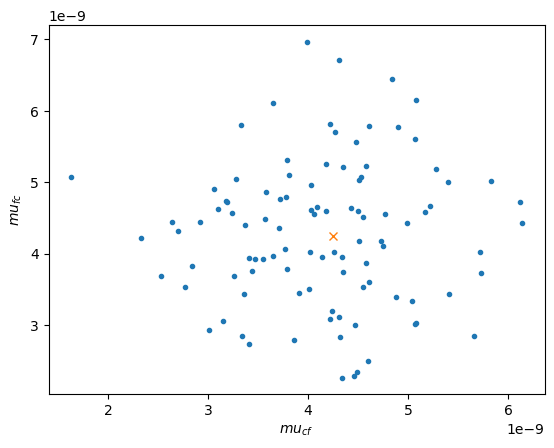

In [24]:
plt.plot(np.array(pos)[:,0], np.array(pos)[:,1], '.')
plt.plot(test_params['mu_fc'], test_params['mu_cf'], 'x')
plt.xlabel(r"$mu_{cf}$")
plt.ylabel(r"$mu_{fc}$")

In [25]:
x = temp_df.day.values
y = temp_df[['frac_small']].values

In [26]:
# Set up the backend
# Don't forget to clear it in case the file already exists
filename = "mcmc_evolution_experiment_parallel.h5"
backend = emcee.backends.HDFBackend(filename)
backend.reset(nwalkers, ndim)

# Initialize the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=(x, y), backend=backend)

In [27]:
max_n = 10000

# We'll track how the average autocorrelation time estimate changes
index = 0
autocorr = np.empty(max_n)

# This will be useful to testing convergence
old_tau = np.inf

# Now we'll sample for up to max_n steps

with Pool() as pool:
    for sample in sampler.sample(pos, iterations=max_n, progress=True):
        # Only check convergence every 100 steps
        if sampler.iteration % 100:
            continue

        # Compute the autocorrelation time so far
        # Using tol=0 means that we'll always get an estimate even
        # if it isn't trustworthy
        tau = sampler.get_autocorr_time(tol=0)
        autocorr[index] = np.mean(tau)
        index += 1

        # Check convergence
        converged = np.all(tau * 100 < sampler.iteration)
        converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
        if converged:
            break
        old_tau = tau

 55%|█████▌    | 5500/10000 [50:37:29<41:25:13, 33.14s/it]   


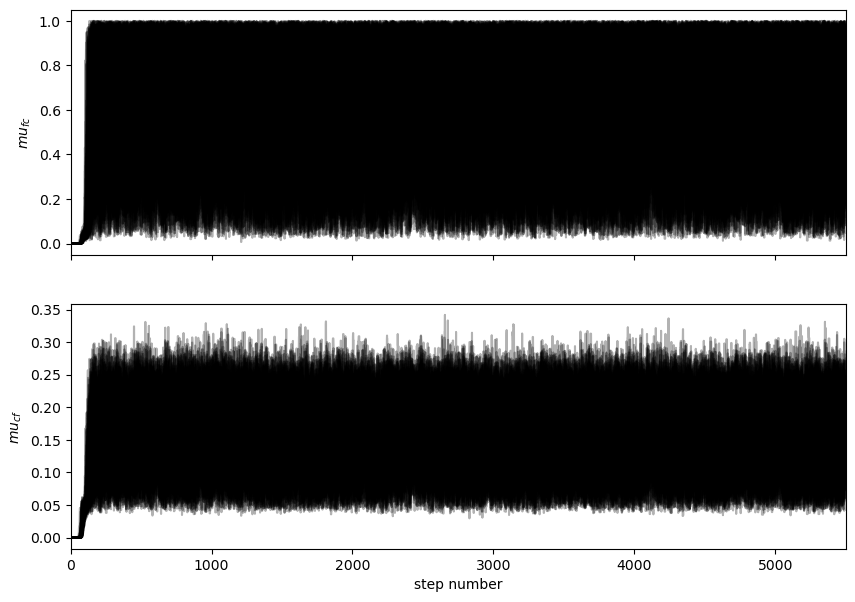

In [28]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = [r"$mu_{fc}$", r"$mu_{cf}$"]
for i in range(2):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    #ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

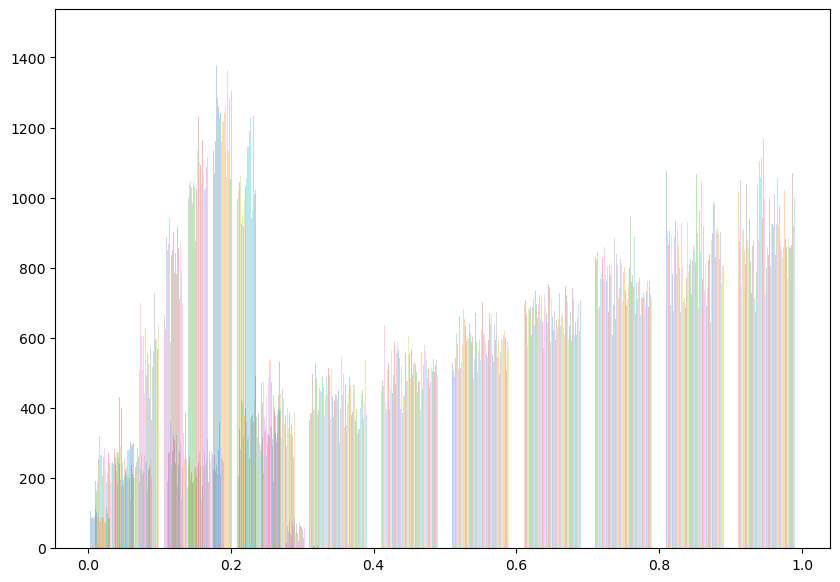

In [31]:
fig, ax = plt.subplots(figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = [r"$mu_{fc}$", r"$mu_{cf}$"]
ax.hist(samples[:, :, 0], alpha=0.3);
ax.hist(samples[:, :, 1], alpha=0.3);
#ax.set_xlim(0, len(samples))
#ax.set_ylabel(labels[i])
#ax.yaxis.set_label_coords(-0.1, 0.5)

#axes[-1].set_xlabel("step number");

In [32]:
samples.shape

(5500, 100, 2)

In [33]:
sampler.get_autocorr_time()

array([51.47620874, 54.32880288])

In [50]:
tau = sampler.get_autocorr_time()
thin = int(0.5 * np.min(tau))
flat_samples = sampler.get_chain(discard = 100, thin = thin, flat = True)
print(flat_samples.shape)

(21600, 2)


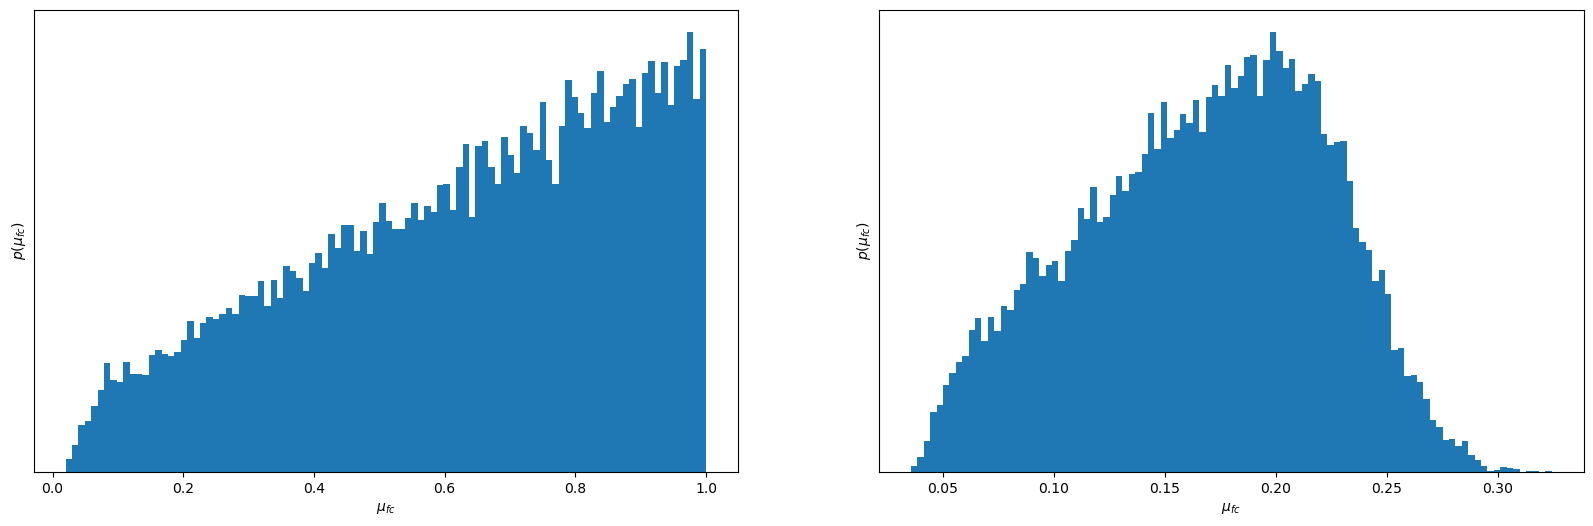

In [51]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(20, 6))
ax[0].hist(flat_samples[:,0], 100)
ax[0].set_yticks([])
ax[0].set_xlabel(r"$\mu_{fc}$")
ax[0].set_ylabel(r"$p(\mu_{fc})$");

ax[1].hist(flat_samples[:,1], 100)
ax[1].set_yticks([])
ax[1].set_xlabel(r"$\mu_{fc}$")
ax[1].set_ylabel(r"$p(\mu_{fc})$");

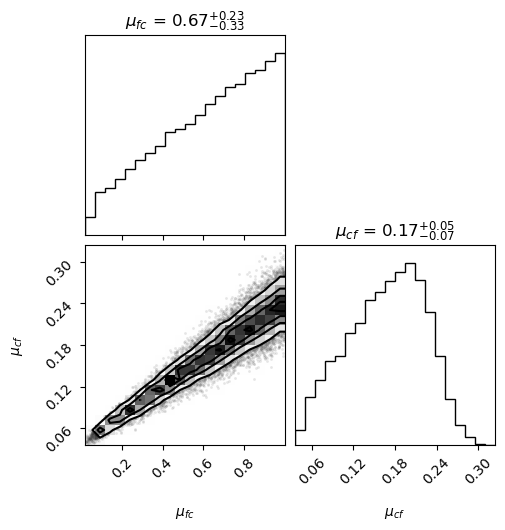

In [58]:
import corner

labels = [r"$\mu_{fc}$", r"$\mu_{cf}$"]
fig = corner.corner(
    flat_samples, labels=labels,
    show_titles = True
);

The title in the plots represent the median of the data with upper and lower bounds

emcee package uses an affine invariant algorithm to run the markov chain